In [4]:
# Import modules
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [5]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Tensorflow Datasets version: {tfds.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Sklearn version: {skl.__version__}")

Tensorflow version: 2.1.0
Tensorflow Datasets version: 3.1.0
Matplotlib version: 3.3.4
Numpy version: 1.18.1
Sklearn version: 0.23.1


In [6]:
print(f"C3 Server version: {c3.Cluster.hosts()[0].serverInfo['buildCITag']}")

C3 Server version: 7.19.1.10-1


# Data Preparation

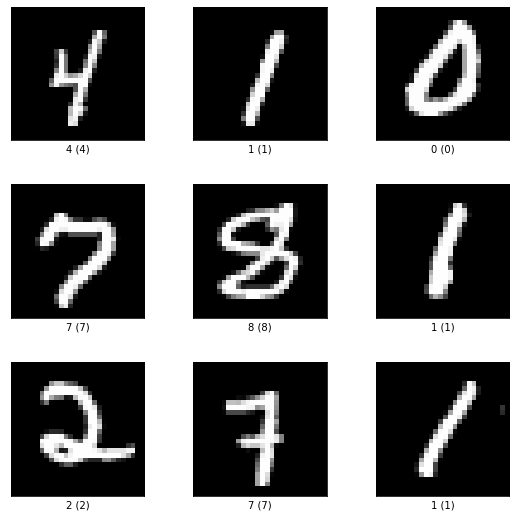

In [7]:
# Plain Tensorflow training cell
ds, info = tfds.load('mnist', split='train', with_info=True)

fig = tfds.show_examples(ds, info)

In [8]:
# From MNIST tensorflow tutorial
# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

# collect all examples and stack'em up for numpy arrays
X_train = []
Y_train = []
for x, y in ds_train:
    X_train.append(x.numpy())
    Y_train.append(y.numpy())

X_train = np.stack(X_train, axis=0)
Y_train = np.stack(Y_train, axis=0)

X_train = X_train.reshape((X_train.shape[0], -1))

X_test = []
Y_test = []
for x, y in ds_test:
    X_test.append(x.numpy())
    Y_test.append(y.numpy())

X_test = np.stack(X_test, axis=0)
Y_test = np.stack(Y_test, axis=0)

X_test = X_test.reshape((X_test.shape[0], -1))

DS_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
DS_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Tensorflow with C3

In [9]:
# C3 Tensorflow training cell

# Put data onto the C3 platform
X_train_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
X_train_source_spec = c3.FileSourceSpec.createFromNumpy(X_train, X_train_spec)
Y_train_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
Y_train_source_spec = c3.FileSourceSpec.createFromNumpy(Y_train, Y_train_spec)
X_test_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
X_test_source_spec = c3.FileSourceSpec.createFromNumpy(X_test, X_test_spec)
Y_test_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
Y_test_source_spec = c3.FileSourceSpec.createFromNumpy(Y_test, Y_test_spec)

In [10]:
# Logistic Regression Pipeline

lrPipe = c3.SklearnPipe(
    name = "logisticRegression",
    technique=c3.SklearnTechnique(
        name = "linear_model.LogisticRegression",
        # calls predict function
        processingFunctionName="predict",
        hyperParameters={"random_state": 42}
    )
)

logisticRegression = c3.MLSerialPipeline(
    name = "lrPipeline",
    steps = [
        c3.MLStep(
            name="lrStep",
            pipe=lrPipe
        )
    ],
    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLAccuracyMetric()])
)

In [12]:
# Train pipeline
# Currently fails with MLAccuracyMetric Bug! (Error while computing scoring metric MLAccuracyMetric (with category PREDICTION) on input computed with predict)
trained_logisticRegression = logisticRegression.train(
    input=c3.Dataset.fromNdArrayStreamable(X_train_source_spec),
    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_train_source_spec))

ERROR:c3iot.ServerConnection:500 - ScriptError - c3.love.exceptions.C3RuntimeException_wrapIt [7902.2719]
message: "Error: Error while computing scoring metric MLAccuracyMetric (with category PREDICTION) on input computed with predict (SklearnApiCommon_score.js#12)"
JSON: {"spec": null, "targetOutput": {"type": "Dataset", "sourceSpec": {"type": "FileNdArraySourceSpec", "locationPrefix": "StressTest", "storageFormat": "NPY", "optimalFileSize": 64000000, "id": "04c97d2f-8887-46eb-a869-f64c1c9ea29c", "meta": {"type": "Meta", "tenantTagId": 30, "tenant": "trainee20", "tag": "featuretrainee20", "created": "2021-06-15T20:39:00+00:00", "createdBy": "mkrafcz2@illinois.edu", "updated": "2021-06-15T20:39:01+00:00", "updatedBy": "mkrafcz2@illinois.edu", "timestamp": "2021-06-15T20:39:01+00:00", "fetchInclude": "[]", "fetchType": "FileNdArraySourceSpec"}, "version": 2, "typeIdent": "FISS:FNDASS", "location": "StressTest/FileSourceSpec/04c97d2f-8887-46eb-a869-f64c1c9ea29c", "uploadInProgress": fals

C3RuntimeException: 500 - ScriptError - c3.love.exceptions.C3RuntimeException_wrapIt [7902.2719]
message: "Error: Error while computing scoring metric MLAccuracyMetric (with category PREDICTION) on input computed with predict (SklearnApiCommon_score.js#12)"
JSON: {"spec": null, "targetOutput": {"type": "Dataset", "sourceSpec": {"type": "FileNdArraySourceSpec", "locationPrefix": "StressTest", "storageFormat": "NPY", "optimalFileSize": 64000000, "id": "04c97d2f-8887-46eb-a869-f64c1c9ea29c", "meta": {"type": "Meta", "tenantTagId": 30, "tenant": "trainee20", "tag": "featuretrainee20", "created": "2021-06-15T20:39:00+00:00", "createdBy": "mkrafcz2@illinois.edu", "updated": "2021-06-15T20:39:01+00:00", "updatedBy": "mkrafcz2@illinois.edu", "timestamp": "2021-06-15T20:39:01+00:00", "fetchInclude": "[]", "fetchType": "FileNdArraySourceSpec"}, "version": 2, "typeIdent": "FISS:FNDASS", "location": "StressTest/FileSourceSpec/04c97d2f-8887-46eb-a869-f64c1c9ea29c", "uploadInProgress": false, "uploadIsBuffered": false, "nextFilePart": 0}}, "input": {"type": "Dataset", "sourceSpec": {"type": "FileNdArraySourceSpec", "locationPrefix": "StressTest", "storageFormat": "NPY", "optimalFileSize": 64000000, "id": "f7121b0a-14cd-409e-bc82-c8c3e75288e0", "meta": {"type": "Meta", "tenantTagId": 30, "tenant": "trainee20", "tag": "featuretrainee20", "created": "2021-06-15T20:38:53+00:00", "createdBy": "mkrafcz2@illinois.edu", "updated": "2021-06-15T20:38:54+00:00", "updatedBy": "mkrafcz2@illinois.edu", "timestamp": "2021-06-15T20:38:54+00:00", "fetchInclude": "[]", "fetchType": "FileNdArraySourceSpec"}, "version": 2, "typeIdent": "FISS:FNDASS", "location": "StressTest/FileSourceSpec/f7121b0a-14cd-409e-bc82-c8c3e75288e0", "uploadInProgress": false, "uploadIsBuffered": false, "nextFilePart": 0}}, "this": {"type": "MLSerialPipeline", "name": "lrPipeline", "noTrainScore": false, "scoringMetrics": {"MLAccuracyMetric": {"type": "MLAccuracyMetric"}}, "untrainableOverride": false, "steps": [{"type": "MLStep", "name": "lrStep", "pipe": {"type": "SklearnPipe", "name": "logisticRegression", "noTrainScore": false, "untrainableOverride": false, "technique": {"type": "SklearnTechnique", "name": "linear_model.LogisticRegression", "hyperParameters": {"random_state": {"type": "int", "value": 42}}, "processingFunctionName": "predict", "keepInputColumnIndices": false}}}]}}